# Задание 3.2 - сверточные нейронные сети (CNNs) в PyTorch

Это упражнение мы буде выполнять в Google Colab - https://colab.research.google.com/  
Google Colab позволяет запускать код в notebook в облаке Google, где можно воспользоваться бесплатным GPU!  

Авторы курса благодарят компанию Google и надеятся, что праздник не закончится.

Туториал по настройке Google Colab:  
https://medium.com/deep-learning-turkey/google-colab-free-gpu-tutorial-e113627b9f5d  
(Keras инсталлировать не нужно, наш notebook сам установит PyTorch)


In [1]:
# Intstall PyTorch and download data
!pip3 install torch torchvision

!wget -c http://ufldl.stanford.edu/housenumbers/train_32x32.mat http://ufldl.stanford.edu/housenumbers/test_32x32.mat

--2022-03-25 19:59:36--  http://ufldl.stanford.edu/housenumbers/train_32x32.mat
Распознаётся ufldl.stanford.edu (ufldl.stanford.edu)… 171.64.68.10
Подключение к ufldl.stanford.edu (ufldl.stanford.edu)|171.64.68.10|:80... соединение установлено.
HTTP-запрос отправлен. Ожидание ответа… 416 Requested Range Not Satisfiable

    Файл уже получен полностью; нет действий.

--2022-03-25 19:59:36--  http://ufldl.stanford.edu/housenumbers/test_32x32.mat
Повторное использование соединения с ufldl.stanford.edu:80.
HTTP-запрос отправлен. Ожидание ответа… 416 Requested Range Not Satisfiable

    Файл уже получен полностью; нет действий.



In [2]:
from collections import namedtuple

import matplotlib.pyplot as plt
import numpy as np
import PIL
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.datasets as dset
from torch.utils.data.sampler import SubsetRandomSampler

from torchvision import transforms

In [3]:
device = torch.device("cuda:0") # Let's make sure GPU is available!

# Загружаем данные

In [4]:
# First, lets load the dataset
data_train = dset.SVHN('./', 
                       transform=transforms.Compose([
                           transforms.ToTensor(),
                           transforms.Normalize(mean=[0.43,0.44,0.47],
                                               std=[0.20,0.20,0.20])                           
                       ])
                      )
data_test = dset.SVHN('./', split='test', transform=transforms.Compose([
                           transforms.ToTensor(),
                           transforms.Normalize(mean=[0.43,0.44,0.47],
                                               std=[0.20,0.20,0.20])                           
                       ]))

Разделяем данные на training и validation.

На всякий случай для подробностей - https://pytorch.org/tutorials/beginner/data_loading_tutorial.html

In [5]:
batch_size = 64

data_size = data_train.data.shape[0]
validation_split = .2
split = int(np.floor(validation_split * data_size))
indices = list(range(data_size))
np.random.shuffle(indices)

train_indices, val_indices = indices[split:], indices[:split]

train_sampler = SubsetRandomSampler(train_indices)
val_sampler = SubsetRandomSampler(val_indices)

train_loader = torch.utils.data.DataLoader(data_train, batch_size=batch_size, 
                                           sampler=train_sampler)
val_loader = torch.utils.data.DataLoader(data_train, batch_size=batch_size,
                                         sampler=val_sampler)

In [6]:
# We'll use a special helper module to shape it into a flat tensor
class Flattener(nn.Module):
    def forward(self, x):
        batch_size, *_ = x.shape
        return x.view(batch_size, -1)

Создадим простейшую сеть с новыми слоями:  
Convolutional - `nn.Conv2d`  
MaxPool - `nn.MaxPool2d`

In [7]:
nn_model = nn.Sequential(
            nn.Conv2d(3, 64, 3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(4),
            nn.Conv2d(64, 64, 3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(4),    
            Flattener(),
            nn.Linear(64*2*2, 10),
          )

nn_model.type(torch.cuda.FloatTensor)
nn_model.to(device)

loss = nn.CrossEntropyLoss().type(torch.cuda.FloatTensor)
optimizer = optim.SGD(nn_model.parameters(), lr=1e-1, weight_decay=1e-4)

Восстановите функцию `compute_accuracy` из прошлого задания.  
Единственное отличие в новом - она должна передать данные на GPU прежде чем прогонять через модель. Сделайте это так же, как это делает функция `train_model`

In [8]:
def train_model(model, train_loader, val_loader, loss, optimizer, num_epochs):    
    loss_history = []
    train_history = []
    val_history = []
    for epoch in range(num_epochs):
        model.train() # Enter train mode
        
        loss_accum = 0
        correct_samples = 0
        total_samples = 0
        for i_step, (x, y) in enumerate(train_loader):
          
            x_gpu = x.to(device)
            y_gpu = y.to(device)
            prediction = model(x_gpu)    
            loss_value = loss(prediction, y_gpu)
            optimizer.zero_grad()
            loss_value.backward()
            optimizer.step()
            
            _, indices = torch.max(prediction, 1)
            correct_samples += torch.sum(indices == y_gpu)
            total_samples += y.shape[0]
            
            loss_accum += loss_value

        ave_loss = loss_accum / i_step
        train_accuracy = float(correct_samples) / total_samples
        val_accuracy = compute_accuracy(model, val_loader)
        
        loss_history.append(float(ave_loss))
        train_history.append(train_accuracy)
        val_history.append(val_accuracy)
        
        print("Average loss: %f, Train accuracy: %f, Val accuracy: %f" % (ave_loss, train_accuracy, val_accuracy))
        
    return loss_history, train_history, val_history
        
def compute_accuracy(model, loader):
    """
    Computes accuracy on the dataset wrapped in a loader
    
    Returns: accuracy as a float value between 0 and 1
    """
    model.eval() # Evaluation mode
    # TODO: Copy implementation from previous assignment
    # Don't forget to move the data to device before running it through the model!
    
    true_Counter = 0 
    total_Counter = 0 
    with torch.no_grad():
        for i_step, (x, y) in enumerate(loader):
                x_gpu = x.to(device)
                y_gpu = y.to(device)
                prediction = torch.argmax(model(x_gpu) , 1)    
                for i in range(len(prediction)):
                    if prediction[i] == y_gpu[i]:
                        true_Counter += float(1)
                total_Counter += float(len(prediction))
                
                del prediction

    return float(true_Counter/total_Counter)

loss_history, train_history, val_history = train_model(nn_model, train_loader, val_loader, loss, optimizer, 5)

Average loss: 1.363599, Train accuracy: 0.545644, Val accuracy: 0.760699
Average loss: 0.692723, Train accuracy: 0.789697, Val accuracy: 0.816258
Average loss: 0.593414, Train accuracy: 0.820923, Val accuracy: 0.832844
Average loss: 0.544684, Train accuracy: 0.836160, Val accuracy: 0.841786
Average loss: 0.512766, Train accuracy: 0.848121, Val accuracy: 0.844379


# Аугментация данных (Data augmentation)

В работе с изображениями одним из особенно важных методов является аугментация данных - то есть, генерация дополнительных данных для тренировки на основе изначальных.   
Таким образом, мы получаем возможность "увеличить" набор данных для тренировки, что ведет к лучшей работе сети.
Важно, чтобы аугментированные данные были похожи на те, которые могут встретиться в реальной жизни, иначе польза от аугментаций уменьшается и может ухудшить работу сети.

С PyTorch идут несколько таких алгоритмов, называемых `transforms`. Более подробно про них можно прочитать тут -
https://pytorch.org/tutorials/beginner/data_loading_tutorial.html#transforms

Ниже мы используем следующие алгоритмы генерации:
- ColorJitter - случайное изменение цвета
- RandomHorizontalFlip - горизонтальное отражение с вероятностью 50%
- RandomVerticalFlip - вертикальное отражение с вероятностью 50%
- RandomRotation - случайный поворот

In [9]:
tfs = transforms.Compose([
    transforms.ColorJitter(hue=.50, saturation=.50),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(50, resample=PIL.Image.BILINEAR),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.43,0.44,0.47],
                       std=[0.20,0.20,0.20])                           
])

# Create augmented train dataset
data_aug_train = dset.SVHN('./', 
                       transform=tfs
                      )

train_aug_loader = torch.utils.data.DataLoader(data_aug_train, batch_size=batch_size, 
                                           sampler=train_sampler)

/home/vbond/Загрузки/Deep-Learning/dlcourse_ai/.venv/lib/python3.8/site-packages/torchvision/transforms/transforms.py:1292: UserWarning: The parameter 'resample' is deprecated since 0.12 and will be removed 0.14. Please use 'interpolation' instead.
  warnings.warn(


Визуализируем результаты агментации (вообще, смотреть на сгенерированные данные всегда очень полезно).

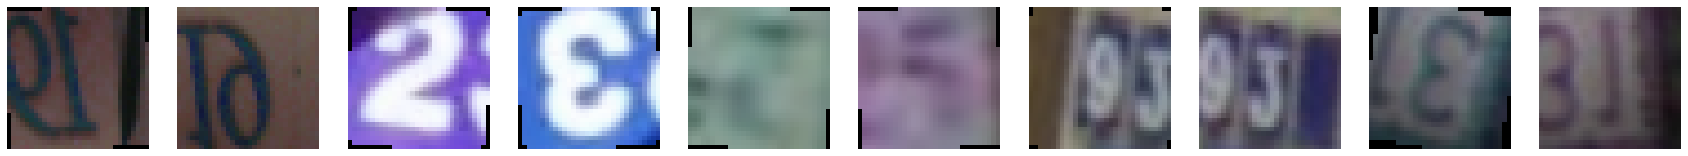

In [10]:
# TODO: Visualize some augmented images!
# hint: you can create new datasets and loaders to accomplish this

# Based on the visualizations, should we keep all the augmentations?

tfs = transforms.Compose([
    transforms.ColorJitter(hue=.20, saturation=.20),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(10, resample=PIL.Image.BILINEAR),
])

data_aug_vis = dset.SVHN('./', 
                       transform=tfs
                      )

plt.figure(figsize=(30, 3))

for i, (x, y) in enumerate(data_aug_vis):
    if i == 10:
        break
    plt.subplot(1, 10, i+1)
    plt.grid(False)
    plt.imshow(x)
    plt.axis('off')

Все ли агментации одинаково полезны на этом наборе данных? Могут ли быть среди них те, которые собьют модель с толку?

Выберите из них только корректные

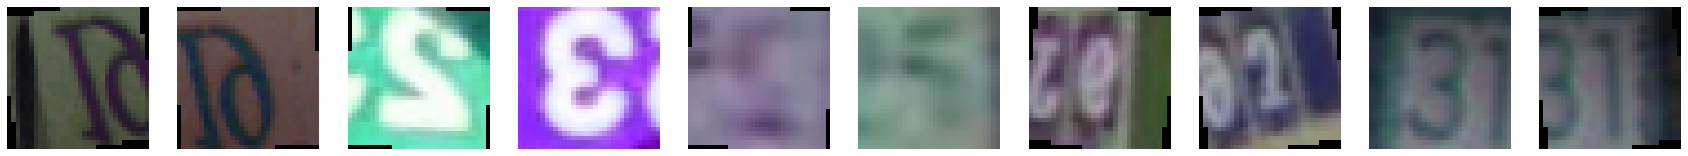

In [11]:
# TODO: 
tfs = transforms.Compose([
    # TODO: Add good augmentations
    transforms.ColorJitter(hue=.20, saturation=.20),
    transforms.RandomRotation(10, resample=PIL.Image.BILINEAR),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.43,0.44,0.47],
                       std=[0.20,0.20,0.20])                           
])

# TODO create new instances of loaders with the augmentations you chose
train_aug_loader = torch.utils.data.DataLoader(data_aug_train, batch_size=batch_size, 
                                           sampler=train_sampler)

plt.figure(figsize=(30, 3))

for i, (x, y) in enumerate(data_aug_vis):
    if i == 10:
        break
    plt.subplot(1, 10, i+1)
    plt.grid(False)
    plt.imshow(x)
    plt.axis('off')

In [12]:
# Finally, let's train with augmentations!

# Note we shouldn't use augmentations on validation

loss_history, train_history, val_history = train_model(nn_model, train_aug_loader, val_loader, loss, optimizer, 5)

Average loss: 1.958920, Train accuracy: 0.308364, Val accuracy: 0.458604
Average loss: 1.710824, Train accuracy: 0.389619, Val accuracy: 0.539212
Average loss: 1.607980, Train accuracy: 0.428864, Val accuracy: 0.487475
Average loss: 1.544120, Train accuracy: 0.456114, Val accuracy: 0.502764
Average loss: 1.497481, Train accuracy: 0.471539, Val accuracy: 0.525698


# LeNet
Попробуем имплементировать классическую архитектуру сверточной нейронной сети, предложенную Яном ЛеКуном в 1998 году. В свое время она достигла впечатляющих результатов на MNIST, посмотрим как она справится с SVHN?
Она описана в статье ["Gradient Based Learning Applied to Document Recognition"](http://yann.lecun.com/exdb/publis/pdf/lecun-01a.pdf), попробуйте прочитать ключевые части и имплементировать предложенную архитетуру на PyTorch.

Реализовывать слои и функцию ошибки LeNet, которых нет в PyTorch, **не нужно** - просто возьмите их размеры и переведите в уже известные нам Convolutional, Pooling и Fully Connected layers.

Если в статье не очень понятно, можно просто погуглить LeNet и разобраться в деталях :)

In [13]:
# TODO: Implement LeNet-like architecture for SVHN task
lenet_model = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=6, kernel_size=5, stride=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2),
            nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5, stride=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2), 
            nn.Conv2d(in_channels=16, out_channels=120, kernel_size=5, stride=1),
            nn.ReLU(inplace=True),
            Flattener(),
            nn.Linear(in_features=120, out_features=84),
            nn.ReLU(inplace=True),
            nn.Linear(in_features=84, out_features=10),
          )

lenet_model.type(torch.cuda.FloatTensor)
lenet_model.to(device)

loss = nn.CrossEntropyLoss().type(torch.cuda.FloatTensor)
optimizer = optim.SGD(lenet_model.parameters(), lr=1e-1, weight_decay=1e-4)

In [14]:
# Let's train it!
loss_history, train_history, val_history = train_model(lenet_model, train_aug_loader, val_loader, loss, optimizer, 10)

Average loss: 2.184181, Train accuracy: 0.206958, Val accuracy: 0.289332
Average loss: 1.684370, Train accuracy: 0.408798, Val accuracy: 0.537438
Average loss: 1.330758, Train accuracy: 0.541634, Val accuracy: 0.569586
Average loss: 1.177212, Train accuracy: 0.599205, Val accuracy: 0.633063
Average loss: 1.095393, Train accuracy: 0.625294, Val accuracy: 0.641117
Average loss: 1.036874, Train accuracy: 0.645378, Val accuracy: 0.656133
Average loss: 1.002483, Train accuracy: 0.657919, Val accuracy: 0.672377
Average loss: 0.973078, Train accuracy: 0.667065, Val accuracy: 0.688895
Average loss: 0.949012, Train accuracy: 0.676927, Val accuracy: 0.678588
Average loss: 0.929217, Train accuracy: 0.681022, Val accuracy: 0.711146


# Подбор гиперпараметров

In [18]:
# The key hyperparameters we're going to tune are learning speed, annealing rate and regularization
# We also encourage you to try different optimizers as well

lenet_model = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=6, kernel_size=5, stride=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2),
            nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5, stride=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2), 
            nn.Conv2d(in_channels=16, out_channels=120, kernel_size=5, stride=1),
            nn.ReLU(inplace=True),
            Flattener(),
            nn.Linear(in_features=120, out_features=84),
            nn.ReLU(inplace=True),
            nn.Linear(in_features=84, out_features=10),
          )

lenet_model.type(torch.cuda.FloatTensor)
lenet_model.to(device)

loss = nn.CrossEntropyLoss().type(torch.cuda.FloatTensor)



Hyperparams = namedtuple("Hyperparams", ['learning_rate', 'reg'])
RunResult = namedtuple("RunResult", ['model', 'train_history', 'val_history', 'final_val_accuracy'])

learning_rates = [1e-1, 1e-2, 1e-3, 1e-4]
anneal_coeff = 0.2
anneal_epochs = [1, 5, 10, 15, 20, 50]
reg = [1e-3, 1e-4, 1e-5]

batch_size = 64
epoch_num = 5

# Record all the runs here
# Key should be Hyperparams and values should be RunResult
run_record = {} 

# Use grid search or random search and record all runs in run_record dictionnary 
# Important: perform search in logarithmic space!

# TODO: Your code here!
for learning_rate in learning_rates:
    for wd in reg:
        print("lr: %f, wd: %f" % (learning_rate, wd))
        optimizer = optim.SGD(lenet_model.parameters(), lr=learning_rate, weight_decay=wd)
        loss_history, train_history, val_history = train_model(lenet_model, train_aug_loader, val_loader, loss, optimizer, epoch_num)
        run_record[Hyperparams(learning_rate, wd)] = RunResult(lenet_model, train_history, val_history, val_history[-1])

lr: 0.100000, wd: 0.001000
Average loss: 2.117243, Train accuracy: 0.236017, Val accuracy: 0.398744
Average loss: 1.540628, Train accuracy: 0.461745, Val accuracy: 0.535117
Average loss: 1.255406, Train accuracy: 0.571546, Val accuracy: 0.595113
Average loss: 1.122107, Train accuracy: 0.617855, Val accuracy: 0.631220
Average loss: 1.049663, Train accuracy: 0.641726, Val accuracy: 0.642960
lr: 0.100000, wd: 0.000100
Average loss: 0.997517, Train accuracy: 0.659284, Val accuracy: 0.653812
Average loss: 0.961191, Train accuracy: 0.671211, Val accuracy: 0.693536
Average loss: 0.937531, Train accuracy: 0.679726, Val accuracy: 0.676404
Average loss: 0.912650, Train accuracy: 0.685971, Val accuracy: 0.692922
Average loss: 0.900438, Train accuracy: 0.690902, Val accuracy: 0.710122
lr: 0.100000, wd: 0.000010
Average loss: 0.886054, Train accuracy: 0.694895, Val accuracy: 0.720360
Average loss: 0.872868, Train accuracy: 0.699297, Val accuracy: 0.719678
Average loss: 0.860097, Train accuracy: 0.7

In [19]:
best_val_accuracy = None
best_hyperparams = None
best_run = None

for hyperparams, run_result in run_record.items():
    if best_val_accuracy is None or best_val_accuracy < run_result.final_val_accuracy:
        best_val_accuracy = run_result.final_val_accuracy
        best_hyperparams = hyperparams
        best_run = run_result
        
print("Best validation accuracy: %4.2f, best hyperparams: %s" % (best_val_accuracy, best_hyperparams))
        

Best validation accuracy: 0.77, best hyperparams: Hyperparams(learning_rate=0.001, reg=1e-05)


# Свободное упражнение - догоним и перегоним LeNet!

Попробуйте найти архитектуру и настройки тренировки, чтобы выступить лучше наших бейзлайнов.

Что можно и нужно попробовать:
- BatchNormalization (для convolution layers он в PyTorch называется [batchnorm2d](https://pytorch.org/docs/stable/nn.html#batchnorm2d))
- Изменить количество слоев и их толщину
- Изменять количество эпох тренировки
- Попробовать и другие агментации

In [20]:
# Best validation accuracy: 0.92, best hyperparams: Hyperparams(learning_rate=0.001, reg=0.0001)
best_model = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=6, kernel_size=7, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(6),
            nn.MaxPool2d(kernel_size=2),
            nn.Conv2d(in_channels=6, out_channels=16, kernel_size=7, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(16),
            nn.MaxPool2d(kernel_size=2), 
            nn.Conv2d(in_channels=16, out_channels=120, kernel_size=7, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(120),
            Flattener(),
            nn.Linear(in_features=120, out_features=84),
            nn.ReLU(inplace=True),
            nn.BatchNorm1d(84),
            nn.Linear(in_features=84, out_features=10),
          )

best_model.type(torch.cuda.FloatTensor)
best_model.to(device)

tfs = transforms.Compose([
    transforms.ColorJitter(hue=.50, saturation=.50),
    transforms.RandomRotation(20, resample=PIL.Image.BILINEAR),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.43,0.44,0.47],
                       std=[0.20,0.20,0.20])                           
])

data_aug_train = dset.SVHN('./', 
                       transform=tfs
                      )

train_aug_loader = torch.utils.data.DataLoader(data_aug_train, batch_size=batch_size, 
                                           sampler=train_sampler)

Hyperparams = namedtuple("Hyperparams", ['learning_rate', 'reg'])
RunResult = namedtuple("RunResult", ['model', 'train_history', 'val_history', 'final_val_accuracy'])
run_record = {} 
learning_rates = [1e-1, 1e-2, 1e-3, 1e-4]
reg = [1e-3, 1e-4, 1e-5]

loss = nn.CrossEntropyLoss().type(torch.cuda.FloatTensor)
for learning_rate in learning_rates:
    for wd in reg:
        print("lr: %f, wd: %f" % (learning_rate, wd))
        optimizer = optim.SGD(best_model.parameters(), lr=learning_rate, weight_decay=wd)
        loss_history, train_history, val_history = train_model(best_model, train_aug_loader, val_loader, loss, optimizer, 10)
        run_record[Hyperparams(learning_rate, wd)] = RunResult(best_model, train_history, val_history, val_history[-1])

best_val_accuracy = None
best_hyperparams = None
for hyperparams, run_result in run_record.items():
    if best_val_accuracy is None or best_val_accuracy < run_result.final_val_accuracy:
        best_val_accuracy = run_result.final_val_accuracy
        best_model = run_result.model
        best_hyperparams = hyperparams

print("Best validation accuracy: %4.2f, best hyperparams: %s" % (best_val_accuracy, best_hyperparams))

lr: 0.100000, wd: 0.001000
Average loss: 0.873274, Train accuracy: 0.716480, Val accuracy: 0.856256
Average loss: 0.529925, Train accuracy: 0.834966, Val accuracy: 0.878916
Average loss: 0.474170, Train accuracy: 0.852728, Val accuracy: 0.884308
Average loss: 0.443301, Train accuracy: 0.864621, Val accuracy: 0.894478
Average loss: 0.418690, Train accuracy: 0.870525, Val accuracy: 0.884376
Average loss: 0.402842, Train accuracy: 0.875849, Val accuracy: 0.902259
Average loss: 0.390017, Train accuracy: 0.880046, Val accuracy: 0.898915
Average loss: 0.385421, Train accuracy: 0.881292, Val accuracy: 0.897959
Average loss: 0.375834, Train accuracy: 0.885148, Val accuracy: 0.903556
Average loss: 0.369570, Train accuracy: 0.886889, Val accuracy: 0.899939
lr: 0.100000, wd: 0.000100
Average loss: 0.359151, Train accuracy: 0.889653, Val accuracy: 0.903829
Average loss: 0.345926, Train accuracy: 0.893509, Val accuracy: 0.905877
Average loss: 0.336803, Train accuracy: 0.896359, Val accuracy: 0.9100

Average loss: 0.162682, Train accuracy: 0.950466, Val accuracy: 0.921371
lr: 0.000100, wd: 0.000010
Average loss: 0.160909, Train accuracy: 0.950790, Val accuracy: 0.922258
Average loss: 0.163022, Train accuracy: 0.950005, Val accuracy: 0.922599
Average loss: 0.161462, Train accuracy: 0.950432, Val accuracy: 0.923418
Average loss: 0.161724, Train accuracy: 0.950159, Val accuracy: 0.922053
Average loss: 0.158475, Train accuracy: 0.951063, Val accuracy: 0.923555
Average loss: 0.159998, Train accuracy: 0.950705, Val accuracy: 0.922190
Average loss: 0.158755, Train accuracy: 0.950551, Val accuracy: 0.922258
Average loss: 0.158264, Train accuracy: 0.950636, Val accuracy: 0.923691
Average loss: 0.161273, Train accuracy: 0.950568, Val accuracy: 0.923077
Average loss: 0.160259, Train accuracy: 0.950193, Val accuracy: 0.922463
Best validation accuracy: 0.92, best hyperparams: Hyperparams(learning_rate=0.001, reg=0.0001)


# Финальный аккорд - проверим лучшую модель на test set

В качестве разнообразия - напишите код для прогона модели на test set вы.

В результате вы должны натренировать модель, которая покажет более **90%** точности на test set.  
Как водится, лучший результат в группе получит дополнительные баллы!

In [21]:
# TODO Write the code to compute accuracy on test set
test_loader = torch.utils.data.DataLoader(data_test, batch_size=batch_size)
final_test_accuracy = compute_accuracy(best_model, test_loader)
print("Final test accuracy - ", final_test_accuracy)

Final test accuracy -  0.9164105716041795
